In [48]:
import csv
import random
import numpy as np # Linear algebra.
import pandas as pd # Data processing.
import itertools #Used in plot_confusion_matrix
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import neighbors
from sklearn.linear_model import SGDClassifier, LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, mean_squared_error

import matplotlib.pyplot as plt
import seaborn

In [49]:
p = 0.01
#Include columns star rating.
#TODO: Try different categories and combinations of cat.
reviews = pd.read_csv("D:/fyp-data/amazon_reviews/amazon_reviews_us_Gift_Card_v1_00.tsv",
                      usecols=['review_body', 'star_rating'], sep='\t', skiprows=lambda i: i>0 and random.random() > p)

#Convert all review bodies from object to string.
reviews["review_body"] = reviews["review_body"].astype(str)
#TODO: Discard reviews with empty bodies.
#reviews.dropna(subset=['review_body'])

In [15]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.lower()
    return df

reviews = standardize_text(reviews, "review_body")

In [16]:
tokenizer = RegexpTokenizer(r'\w+')

reviews.dropna(subset=['review_body'])
reviews["tokens"] = reviews["review_body"].apply(tokenizer.tokenize)

In [17]:
reviews.head()
reviews.tail()
reviews.groupby("star_rating").count()
reviews.describe()

,star_rating
count,1462.000000
mean,4.697674
std,0.900366
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [10]:
reviews["sentiment_score"] = reviews["tokens"].apply(get_sentiment_score)

NameError: name 'get_sentiment_score' is not defined

In [18]:
all_words = [word for tokens in reviews["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in reviews["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

36726 words total, with a vocabulary size of 2916


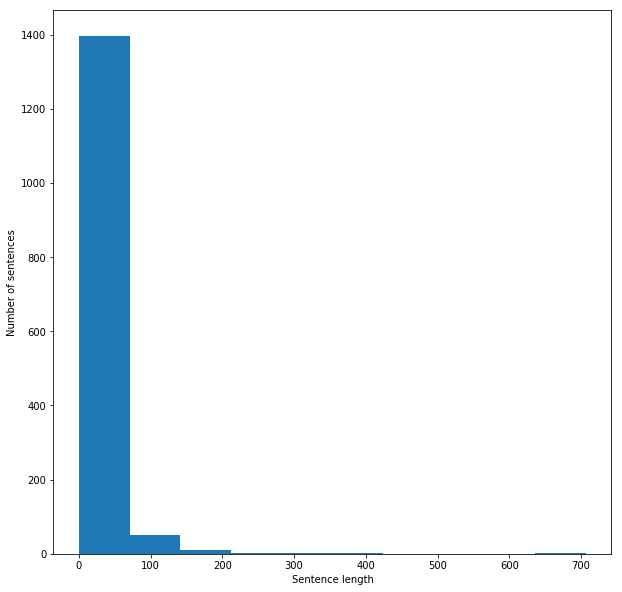

In [19]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [32]:
def cv(data):
    vectorizer = CountVectorizer()

    emb = vectorizer.fit_transform(data)
    return emb, vectorizer

In [33]:
def tfidf(data):
    vectorizer = TfidfVectorizer()
    
    train = vectorizer.fit_transform(data)
    return train, vectorizer

In [34]:
features = reviews["review_body"].tolist()
labels = reviews["star_rating"].tolist()
#Splitting train/test data 80/20 know as Pareto principle.
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [35]:
X_train, count_vectorizer = cv(X_train)
X_test = count_vectorizer.transform(X_test)

In [36]:
X_train, vectorizer = tfidf(X_train)
X_test = _vectorizer.transform(X_test)

AttributeError: lower not found

In [ ]:
def get_metrics(y_test, y_predicted):  
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')     
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # f1 = harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    return accuracy, precision, recall, f1

In [43]:
def print_metrics(y_test, y_predicted):
    accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
    print("accuracy = %.9f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [46]:
#Logistic regression
regressor = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial',
                         n_jobs=-1, random_state=40)
model = regressor.fit(X_train, y_train)

predicted = regressor.predict(X_test)

print_metrics(y_test, predicted)

accuracy = 0.703071672, precision = 0.797, recall = 0.703, f1 = 0.744


In [47]:
#K-nearest neighbours
classifier = neighbors.KNeighborsClassifier(n_neighbors = 6)
model = classifier.fit(X_train, y_train)

predicted = model.predict(X_test)
print_metrics(y_test, predicted)

accuracy = 0.846416382, precision = 0.738, recall = 0.846, f1 = 0.789


C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
#Linear regression 
lr = LinearRegression()
model = lr.fit(X_train, y_train)

predicted = model.predict(X_test)

mean_squared_error(y_test, predicted)
model.score(X_test,y_test)

RMSE:  11.882587614361764


In [ ]:
def load_embeddings(filename):
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('D:/fyp-data/word_embeddings/glove.42B.300d.txt')
embeddings.shape

In [ ]:
def load_lexicon(filename):
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('D:/fyp-data/sentiment_lexicons/positive-words.txt')
neg_words = load_lexicon('D:/fyp-data/sentiment_lexicons/negative-words.txt')

In [ ]:
pos_vectors = embeddings.reindex(pos_words).dropna()
neg_vectors = embeddings.reindex(neg_words).dropna()

In [ ]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [ ]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [ ]:
model = SGDClassifier(loss='log', random_state=0, max_iter=100)
model.fit(train_vectors, train_targets)
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False)

In [ ]:
accuracy_score(model.predict(test_vectors), test_targets)

In [ ]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:10]

In [ ]:
def get_sentiment_score(text):
    sentiment = words_to_sentiment(text)
    return sentiment['sentiment'].mean()